In [2]:
import torch
torch.__version__

'2.2.1+cu121'

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Data loading and preprocessing 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [49]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape  
# So one test data batch is a  tensor of shape: . This means we have 64 examples of 28x28 pixels in grayscale 
# (i.e. no rgb channels, hence the one). We can plot some of them using matplotlib.

torch.Size([64, 1, 28, 28])

In [50]:
print("Batch index: ", batch_idx)
print("Example data: ", example_data.shape)
print("Example target: ", example_targets)

Batch index:  0
Example data:  torch.Size([64, 1, 28, 28])
Example target:  tensor([2, 4, 7, 4, 5, 9, 2, 1, 3, 2, 1, 7, 9, 9, 6, 7, 9, 9, 0, 9, 3, 0, 8, 7,
        7, 7, 5, 2, 7, 8, 7, 3, 1, 1, 3, 7, 6, 1, 5, 6, 5, 4, 9, 2, 4, 2, 0, 9,
        0, 8, 9, 1, 6, 3, 0, 2, 8, 5, 9, 5, 9, 6, 9, 3])


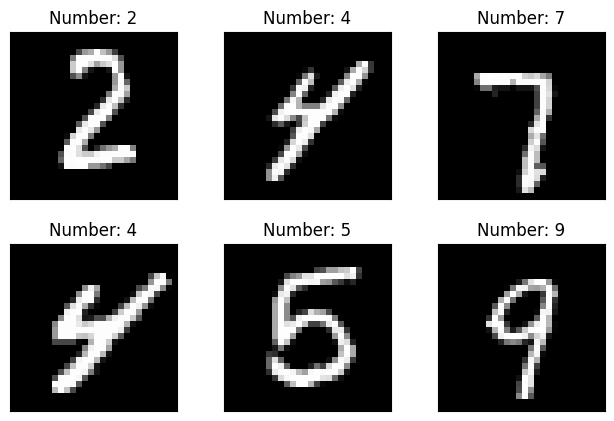

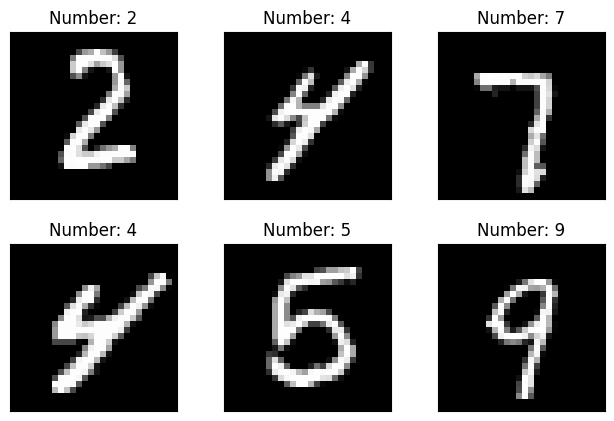

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Number: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [52]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()  # [64, 1, 28, 28]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [54]:
# Initialize the model, loss function, and optimizer
model = SimpleCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the network
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 300 == 299:  # Print loss every 300 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 300))
            running_loss = 0.0

print('Finished Training')

[1,   300] loss: 0.272
[1,   600] loss: 0.076
[1,   900] loss: 0.062
[2,   300] loss: 0.044
[2,   600] loss: 0.040
[2,   900] loss: 0.041
[3,   300] loss: 0.027
[3,   600] loss: 0.030
[3,   900] loss: 0.031
[4,   300] loss: 0.019
[4,   600] loss: 0.023
[4,   900] loss: 0.023
[5,   300] loss: 0.012
[5,   600] loss: 0.014
[5,   900] loss: 0.018
Finished Training


In [55]:
# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %
